In [187]:
from ipywidgets import widgets
from ipywidgets import Layout
from IPython import display
import numpy as np
import serial
import time
import sys
import glob
import io

def serial_ports():
    if sys.platform.startswith('win'):
        ports = ['COM%s' % (i + 1) for i in range(256)]
    elif sys.platform.startswith('linux') or sys.platform.startswith('cygwin'):
        # this excludes your current terminal "/dev/tty"
        ports = glob.glob('/dev/tty[A-Za-z]*')
    elif sys.platform.startswith('darwin'):
        ports = glob.glob('/dev/tty.*')
    else:
        raise EnvironmentError('Unsupported platform')

    result = []
    for port in ports:
        try:
            s = serial.Serial(port)
            s.close()
            result.append(port)
        except (OSError, serial.SerialException):
            pass
    return result

def send_printer(cmd='', show=False):
    global ser_p
    ser_p.write(cmd)
    out = b''
    while ser_p.inWaiting() > 0:
        out += ser_p.read(1)
    if out != '':
        if show:
            print (out)
    return out

def read_scale(n):
    ser_s.reset_input_buffer()
    res=[ser_s.readline() for i in range(n)]
    return [float(res[i].decode()) for i in range(len(res))]

def read_scale_times(t_s=1.):
    res=[]
    res_t=[]
    ser_s.reset_input_buffer()
    start = time.time()

    while (time.time()-start<=t_s):
        res.append(ser_s.readline())
        res_t.append(time.time()-start)
    res=[float(res[i].decode()) for i in range(len(res))]
    
    return res,res_t
    
sports=serial_ports()
ser_p = serial.Serial(sports[0], baudrate=115200) #3d printer
ser_s = serial.Serial(sports[1], baudrate=115200, timeout=5)  #scale

send_printer(b'M203 Z20\r\n') #increase maximum feedrate for z-axis

send_printer(b'M107\r\n') #fan off is needed
#2mm/s = 2*60 mm/min=180
send_printer(b'G1 F500\r\n')
send_printer(b'G91\r\n') #relative positioning


b''

In [ ]:
import matplotlib.pyplot as plt
nn=10
rate=.5 #frequency of up/down
speed=258./2.*rate
deltaz=.6
send_printer('G1 F{:d}\r\n'.format(int(speed*deltaz)).encode())
for i in range(nn):
    print(send_printer('G0 Z{:4.1f}\n'.format(-deltaz).encode()))
    print(send_printer('G0 Z{:4.1f}\n'.format(deltaz).encode()))
    
%time y,x=read_scale_times(nn/rate)


b''
b''
b''
b''
b''
b''
b''
b''
b''
b'ok\nok\n'
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''


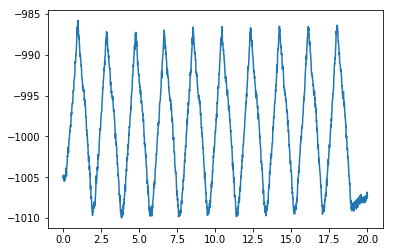

In [228]:
from scipy.signal import find_peaks
xnp=np.array(x,dtype=np.float32)
ynp=np.array(y,dtype=np.float32)
peaks, _ = find_peaks(y, height=ynp.max()/2., distance=len(y)/2./nn)
plt.plot(xnp, ynp)
for i in range(len(peaks)):
    plt.text(xnp[peaks[i]], ynp[peaks[i]],str(i))

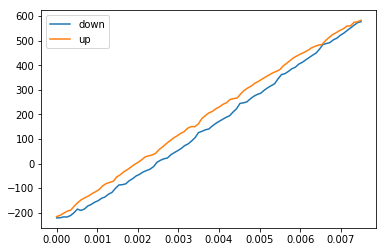

In [222]:
peak_i=-6 #peak position to analyse
g=9.81    #gravitational acceleration
obj_h=40 #height in mm
obj_A=4e-2*4e-2 #Area in m2
down_start_index=int(peaks[peak_i-1]+(peaks[peak_i]-peaks[peak_i-1])/2.)#find down start index
down_end_index=peaks[peak_i]
up_start_index=peaks[peak_i-1]
down_stroke=ynp[down_start_index:down_end_index]
up_stroke=ynp[up_start_index:down_start_index-1]
down_pos=np.linspace(0,deltaz,len(down_stroke))
up_pos=deltaz-np.linspace(0,deltaz,len(up_stroke))
up_strain=up_pos/obj_h
down_strain=down_pos/obj_h
up_stress=up_stroke*1e-3*g/obj_A
down_stress=down_stroke*1e-3*g/obj_A

plt.plot(down_strain,down_stress,label='down');
plt.plot(up_strain,up_stress,label='up')
plt.legend();

In [231]:
print('G0 Z{:4.1f}\r\n'.format(-deltaz).encode())

b'G0 Z-0.3\r\n'
